In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from collections import deque

In [2]:
import sklearn

In [3]:
sklearn.__version__

'1.3.0'

In [23]:
def cal_clust_silhouette(adata, n_pcs, resolution):
    tmp_adata = sc.pp.neighbors(adata, n_pcs=n_pcs, copy=True)
    sc.tl.umap(tmp_adata)
    sc.tl.leiden(tmp_adata, key_added="leiden_res", resolution=resolution)
    return silhouette_score(tmp_adata.X, tmp_adata.obs['leiden_res'])

# Preprocess

## read data

In [10]:
rep1 = sc.read('../scdata_rep1/1.QC.h5ad')
rep2 = sc.read('../scdata_rep2/1.QC.h5ad')

In [11]:
rep1

AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
rep2

AnnData object with n_obs × n_vars = 2797 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## check gene names of two Anndata

In [13]:
var_names = rep1.var_names.intersection(rep2.var_names)
rep1 = rep1[:, var_names]
rep2 = rep2[:, var_names]

len(var_names)

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


19804

## concat AnnData

In [14]:
adata = rep1.concatenate(rep2, batch_categories=["rep1", "rep2"])
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

AnnData object with n_obs × n_vars = 7147 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2'

## normalization and peak find variable genes

In [17]:
# normalization 
sc.pp.normalize_total(adata)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)

adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [18]:
# save data
adata.write("1.before_integrate.h5ad")

# Intergrate data by Harmonoy

In [19]:
# read in data
adata = sc.read('./1.before_integrate.h5ad')
adata

AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [21]:
# run PCA
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
2024-03-26 15:23:09,497 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-26 15:23:19,807 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-26 15:23:20,018 - harmonypy - INFO - Iteration 1 of 10
2024-03-26 15:23:24,104 - harmonypy - INFO - Iteration 2 of 10
2024-03-26 15:23:28,036 - harmonypy - INFO - Iteration 3 of 10
2024-03-26 15:23:31,221 - harmonypy - INFO - Iteration 4 of 10
2024-03-26 15:23:34,803 - harmonypy - INFO - Iteration 5 of 10
2024-03-26 15:23:38,576 - harmonypy - INFO - Iteration 6 of 10
2024-03-26 15:23:42,405 - harmonypy - INFO - Iteration 7 of 10
2024-03-26 15:23:46,399 - harmonypy - INFO - Iteration 8 of 10
2024-03-26 15:23:49,060 

In [ ]:
adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

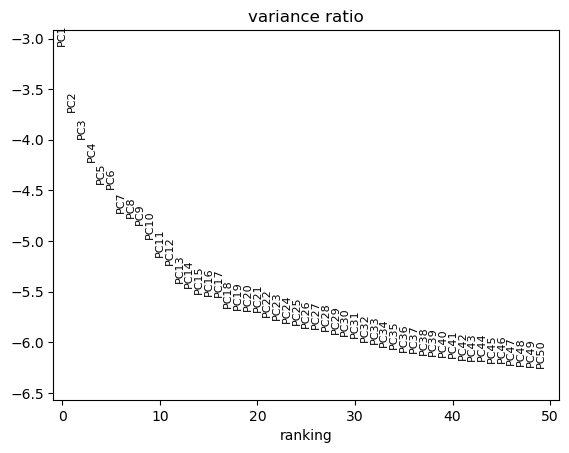

In [63]:
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [25]:
# save data
adata.write("2.integrated.h5ad")
# show Anndata
adata

AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

# clustering

## arguments selection

In [38]:
args_res = deque()
all_pcs = np.linspace(15, 20, 6).astype(int)
all_reses = np.linspace(0.1, 0.9, 5)

count = 0
total_process = len(all_pcs) * len(all_reses)
for pcs in all_pcs:
    for res in all_reses:
        count += 1

        sil = cal_clust_silhouette(adata, pcs, res)
        args_res.append([pcs, res, sil])

        if count % 3 == 0:
            print(f'Processing {count}/{total_process}')
        
args_res_df = pd.DataFrame(args_res, columns=['n_pcs', 'resolution', 'silhouette_score'])

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/public21/home/sc90258/miniconda3/envs/hy-

Processing 3/30
Processing 6/30
Processing 9/30
Processing 12/30
Processing 15/30
Processing 18/30
Processing 21/30
Processing 24/30
Processing 27/30
Processing 30/30


In [39]:
best_args = args_res_df[args_res_df['silhouette_score'] == args_res_df['silhouette_score'].max()]
best_args

,n_pcs,resolution,silhouette_score
15,18,0.1,-0.034361


In [40]:
args_res_df.to_csv('./2.arg_select.csv', index=False)

## plot UMAP

/tmp/ipykernel_25430/3086038833.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
/tmp/ipykernel_25430/3086038833.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `

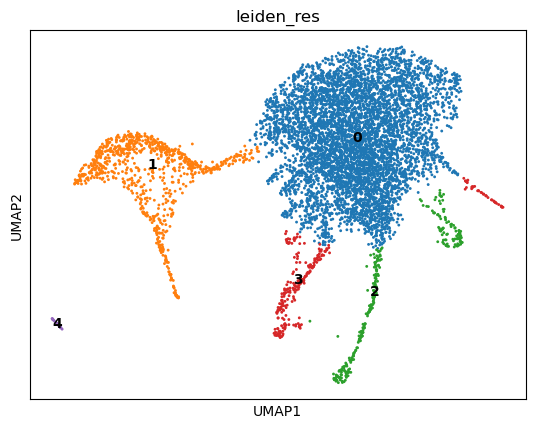

In [52]:
adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [ ]:
adata.obs['leiden_res'].value_counts()

leiden_res
0    5684
1     850
2     314
3     274
4      25
Name: count, dtype: int64

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


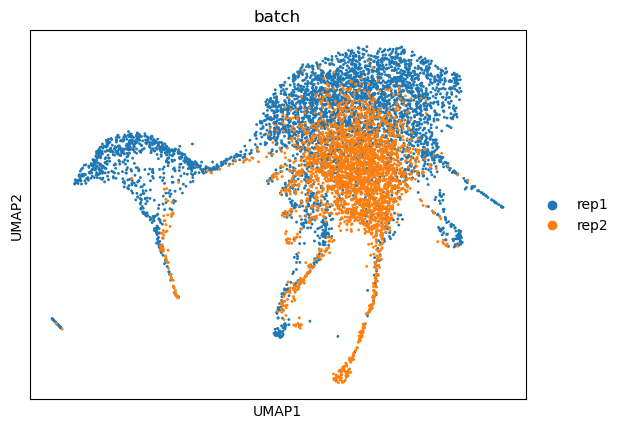

In [57]:
sc.pl.umap(
    adata,
    color=["batch"],
)

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color

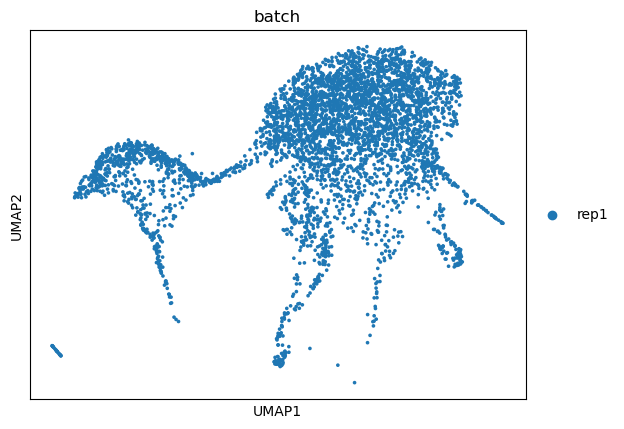

In [60]:
sc.pl.umap(adata[adata.obs['batch'] == 'rep1'], color=["batch"])

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color

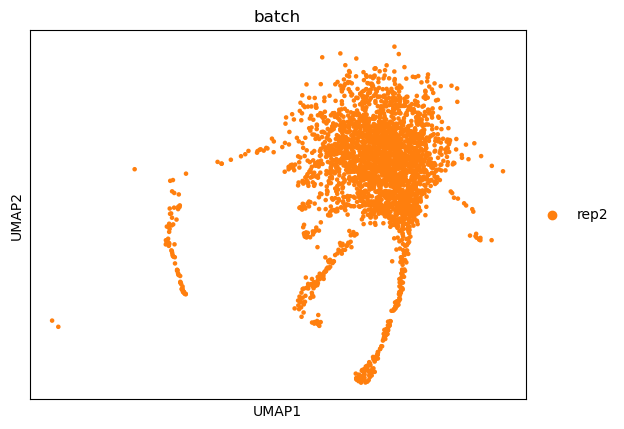

In [61]:
sc.pl.umap(adata[adata.obs['batch'] == 'rep2'], color=["batch"])

In [43]:
# save data
adata.write("3.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./3.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [19]:
adata.obs[adata.obs['leiden_res'] == '1'].to_csv('./4.cluster1.csv')
adata.obs[adata.obs['leiden_res'] == '2'].to_csv('./4.cluster2.csv')
adata.obs[adata.obs['leiden_res'] == '3'].to_csv('./4.cluster3.csv')

## make marker genes dict

In [3]:
marker_genes = {
    'ISC/EB': ['AAEL013544', 'AAEL025606'], # Klu, Delta
    'Cardia': ['AAEL004522'], # gambicin
    'EC-like': ['AAEL008769', 'AAEL009330'], # SP24D, AeCA  # ['AAEL007818', 'AAEL001863'], # trypsin 3A1, Carboxypeptidase
    'EC': ['AAEL017445'], # Nubbin
    'EE': ['AAEL002769', 'AAEL002733'], # prospero, NPF
    'VM': ['AAEL001673'], # Actin
    'FBC': ['AAEL008789'], # apoLp-III 'https://www.science.org/doi/10.1126/science.abc0322#supplementary-materials' (table s5)
    'HC': ['AAEL008658'], # LRIM16
}

## plot marker genes on UMAP

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: F

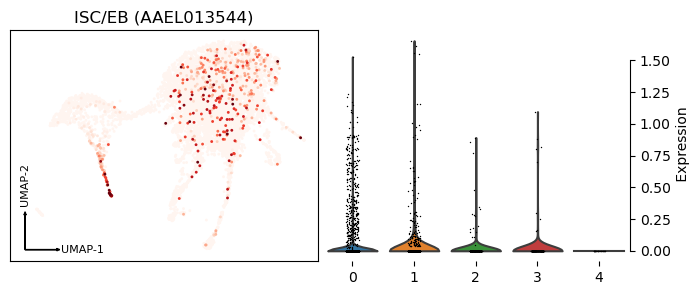

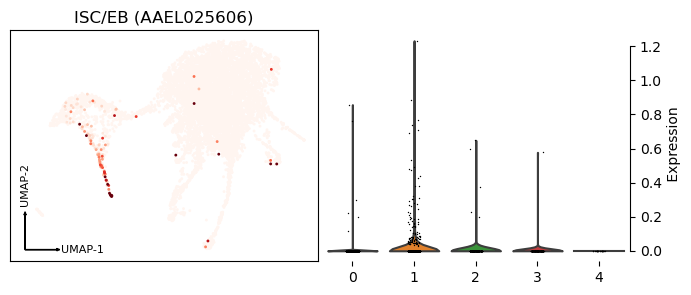

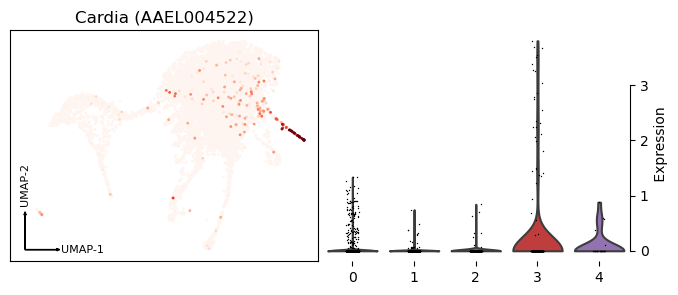

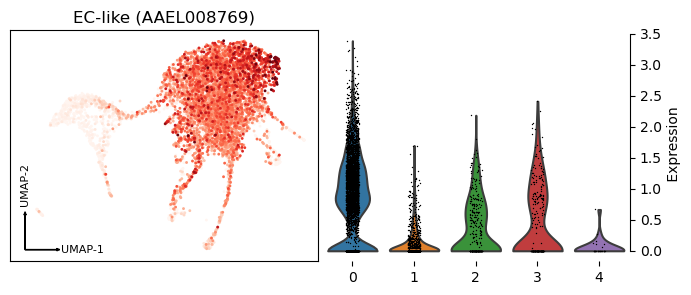

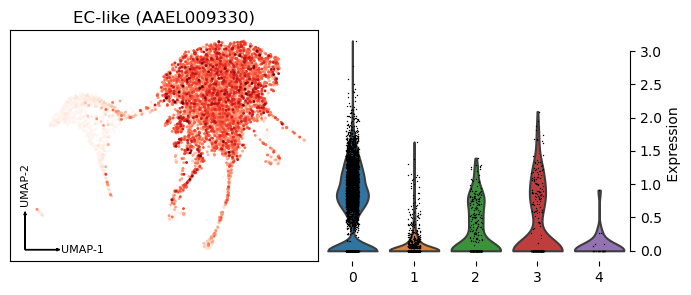

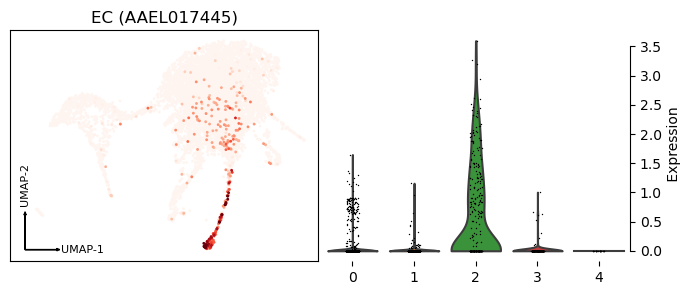

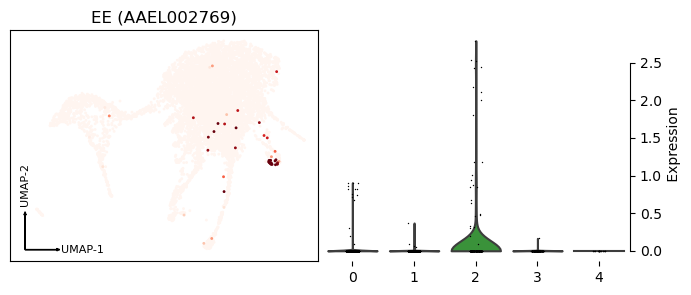

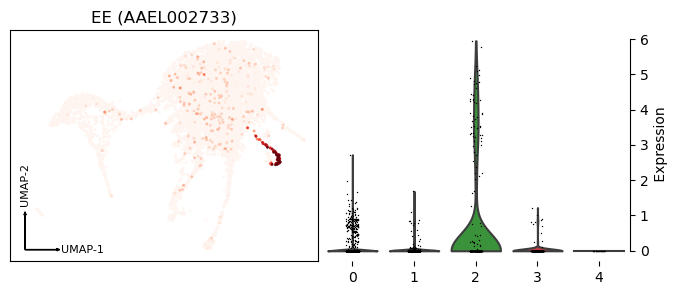

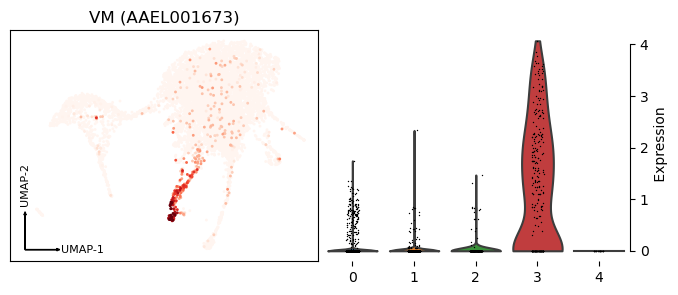

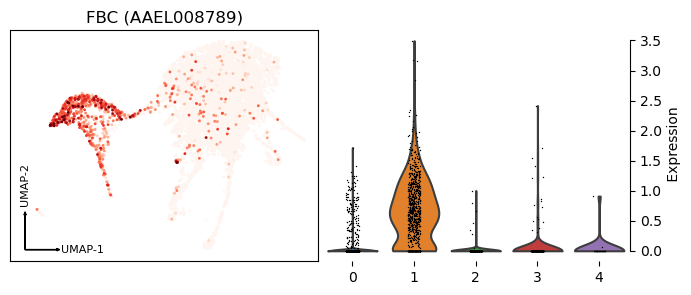

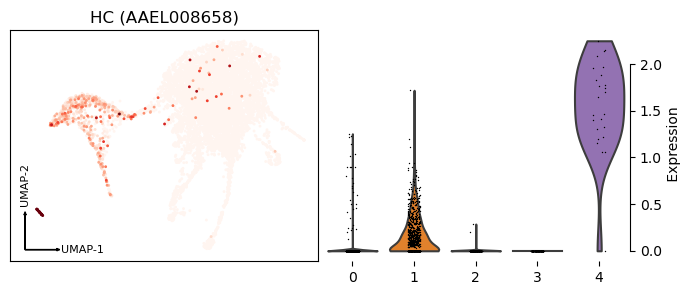

In [4]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax1, show=False
    )

    ax1.arrow(
        -6.5, -3, 0, 3, 
        width=0.01, head_width=0.2, overhang=0.3, 
        color='k', zorder=10)
    ax1.arrow(
        -6.5, -3, 3, 0, 
        width=0.01, head_width=0.2, overhang=0.3,
        color='k', zorder=10)

    ax1.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    ax1.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    # ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    # ax1.set_xlim(-7.5, 21)
    # ax1.set_ylim(-3.6, 16)

    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax2, show=False
    )

    ax2.set_xlabel('')

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(' Expression')
    ax2.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax2)

    # plot title
    # ax1.plot((-6.5, 50), (19,19), '-k', clip_on=False, zorder=100)
    # ax1.text((-6.5 + 50) / 2, 19.2, f'{cluster} ({marker})', ha='center', va='bottom')

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

for cluster in marker_genes.keys():
    for marker in marker_genes[cluster]:

        plot_umap_violin_rep(
            adata, marker, cluster, 
        )

HC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


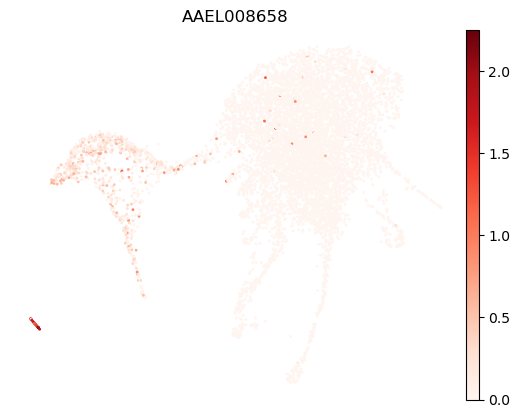

ISC/EB


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


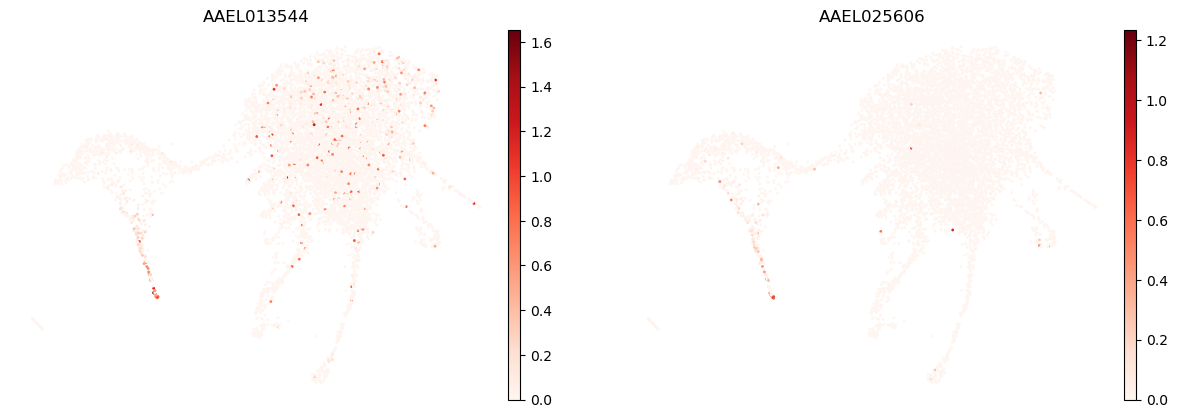

cardia


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


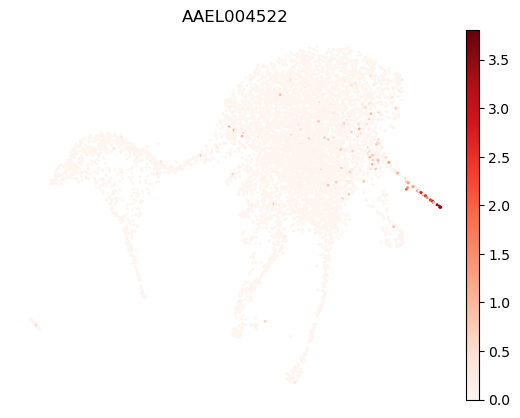

EE


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


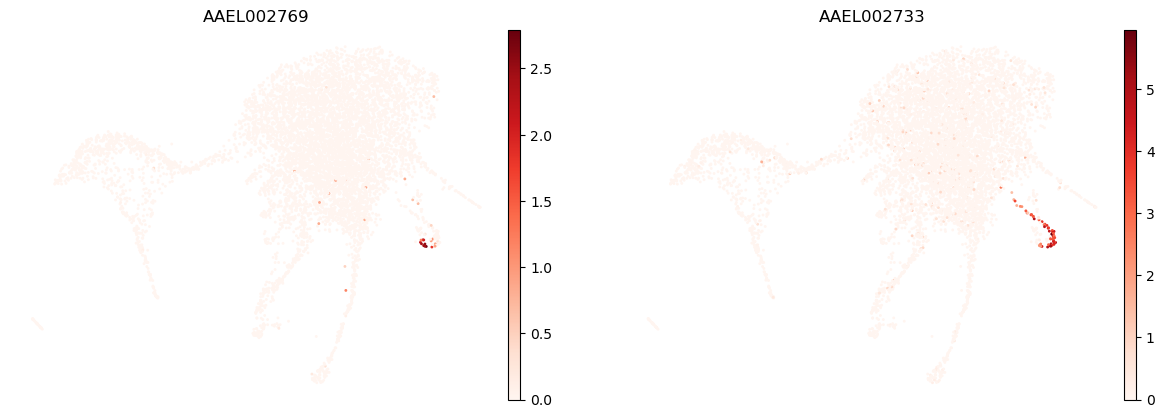

VM


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


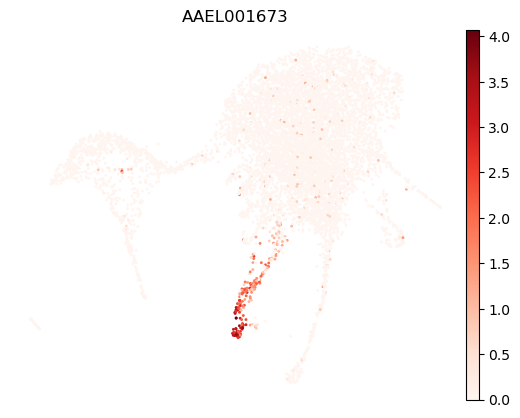

FBC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


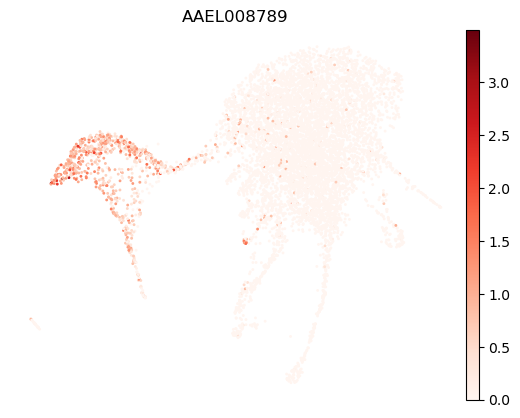

EC-im


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


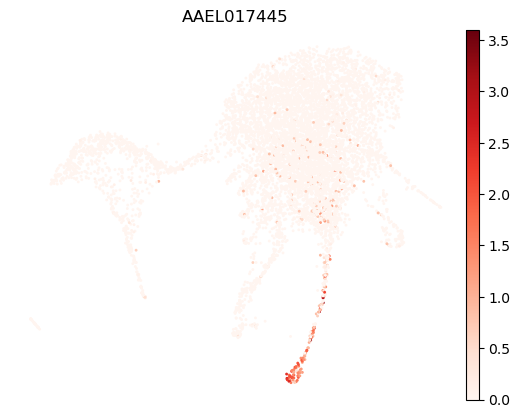

EC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


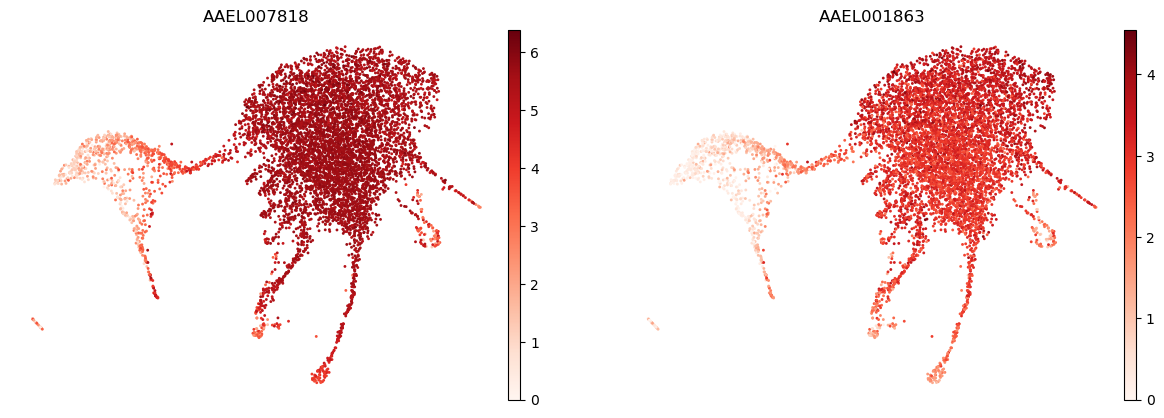

In [29]:
for ct in marker_genes.keys():
    print(ct)
    sc.pl.umap(
        adata,
        color=marker_genes[ct],
        vmin=0,
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )

## plot marker genes by violin plot

HC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

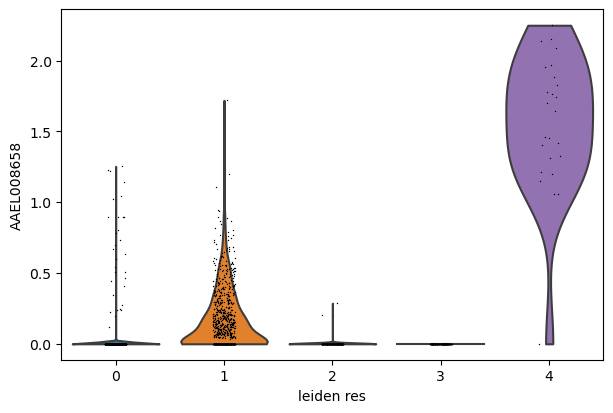

ISC/EB


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

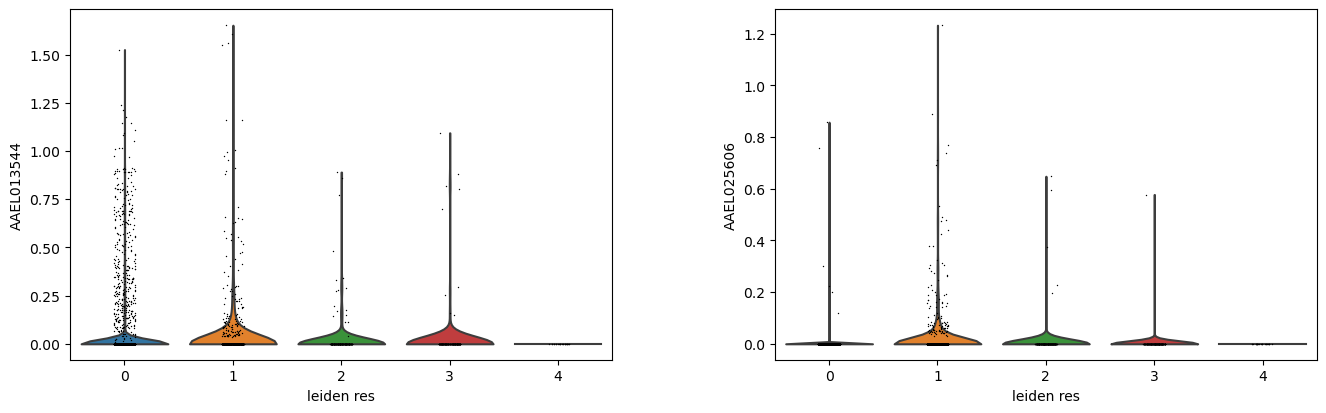

cardia


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

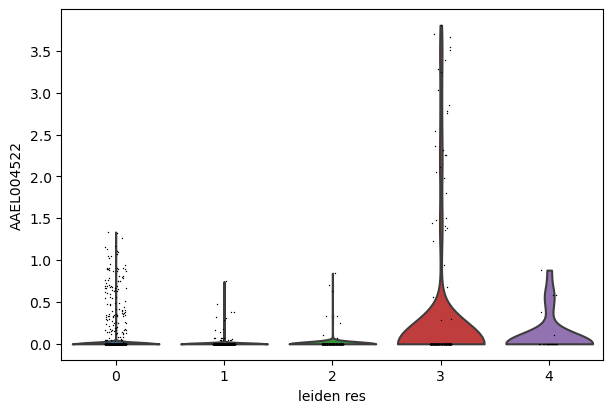

EE


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

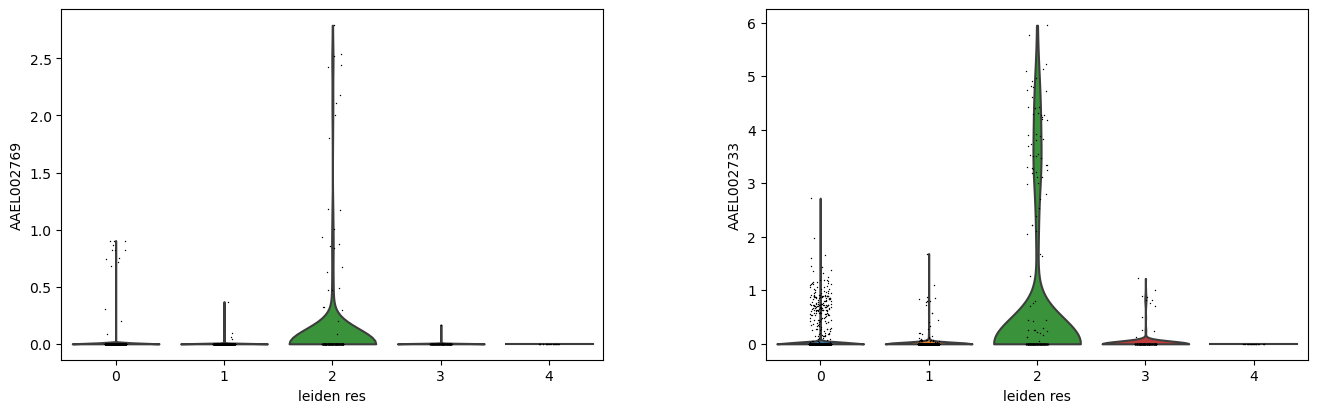

VM


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

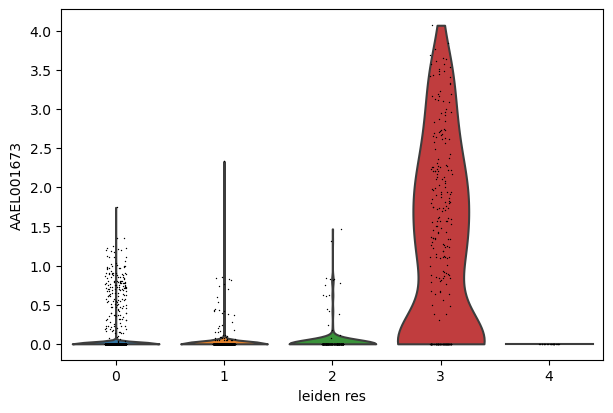

FBC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

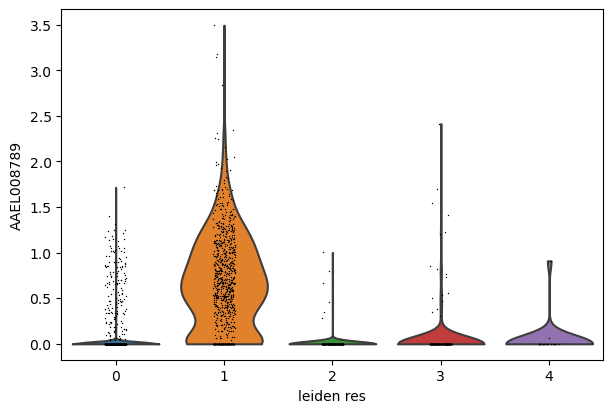

EC-im


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

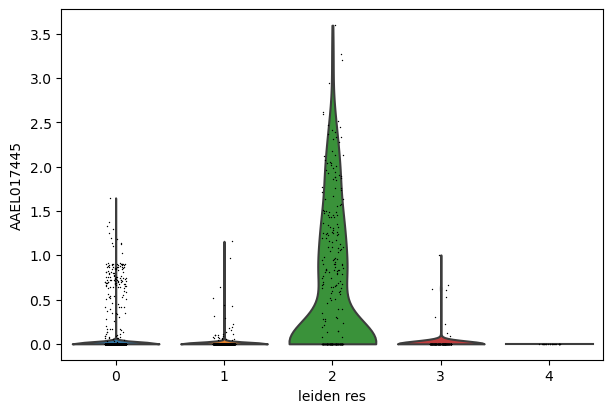

EC


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/public21/home/sc90258/mini

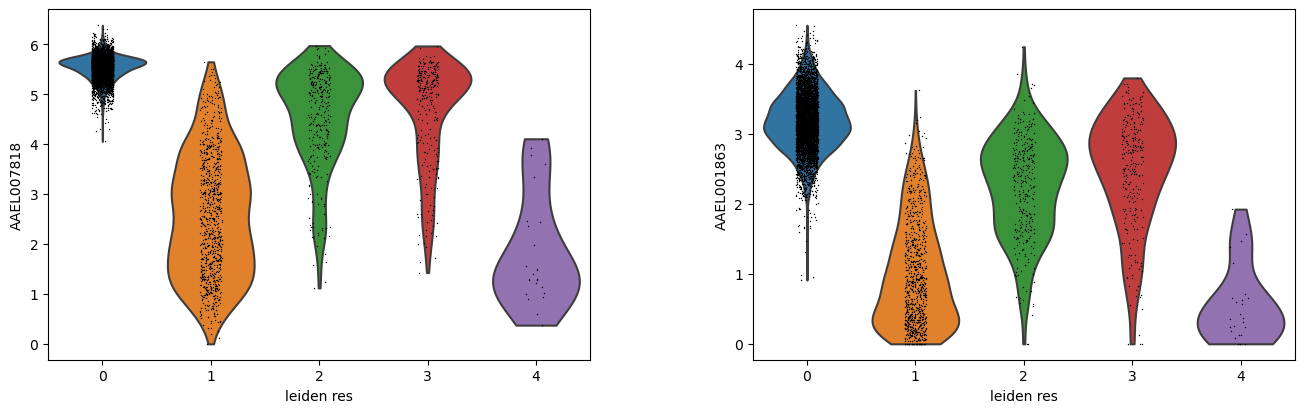

In [30]:
for ct in marker_genes.keys():
    print(ct)
    sc.pl.violin(
        adata,
        marker_genes[ct],
        groupby='leiden_res',
    )

In [48]:
# save data
adata.write("4.Annotation.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 7147 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'